# Lecture 20: Classification of Astronomical Images with Deep Learning

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Lecture20.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and many others.

<a id='toc'></a>

## This notebook includes:


[Introduction to Deep Learning](#intro) 

[Example: Image classification with ResNet](#resnet) 


## Introduction to Deep Learning <a id='intro'></a>

#### Originally developed by Andy Connolly for 
[astroML workshop at the 235th Meeting of the American Astronomical Society (January 6, 2020)](http://www.astroml.org/workshops/AAS235.html)

ResNet50 example based on on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb


We use a sample of simulated stamps with three balanced classes: **star** (i.e. point spread function), a **moving source** (a.k.a. trailed source) and the so-called **"dipole"** source generated by subtracting two identical stars with somewhat mismatched positions (a fraction of pixels, due to e.g., bad astrometry or proper motion). The code 
that generated these images is in [makeSampleResNet.ipynb notebook](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/makeSampleResNet.ipynb).

**Deep learning**, an extension of the neural networks that were
popularized in the 1990s. The concepts are inspired
by the structure and function of the brain. A neuron in the brain is a
core computational unit that takes a series of inputs from branched
extensions of the neuron called dendrites, operates on these inputs,
and generates an output that is transmitted along an axon to one or
more other neurons. In the context of a neural network a neuron, $j$, takes a set of inputs,
$x_i$, applies a, typically non-linear, function to these inputs and
generates an output value. Networks are then created by connecting
multiple neurons or layers of neurons to one another.

![Neural Network Diagram](figures/fig_neural_network-1.png)

If we consider the simplified network
inputs are passed to the neurons in the
network. Each input is weighted by a value, $w_{ij}$ and the sum of
these weighted inputs is operated on by a response or activation
function $f(\theta)$, which transform
the input signal so that it varies between 0 and 1 through the
application of a non-linear response. The output from any neuron is
then given by,

$$
a_j =  f  \left( \sum_i w_{ij} x_i + b_j \right)
$$

where $b_j$ is a bias term which determines the input level at which the
neuron becomes activated.

We refer to the neurons between the inputs and the output layers as
the hidden layers. If the neurons from one layer connect to all
neurons in a subsequent layer we call this a fully connected layer.
When the outputs from the neurons only connect to subsequent layers
(i.e. the graph is acyclic) we refer to this as a feed-forward
network -- this is the most common
structure for a neural network used in classification. 

The final layer in the network is the output layer. As with the hidden
layer, an activation function, $g(\theta)$, in the output layer acts
on the weighted sum of its inputs.  In this figure we have a single
output node but there can be multiple outputs. For our example  network the
output from the final neuron, $y_k$, would be given by

$$
y_k = g \left( \sum_j   w_{jk} a_j  + b_k \right)  = g\left( \sum_j
  w_{jk}  f \left( \sum_i w_{ij} x_i + b_j\right) + b_k\right)
$$

**Training of the network is simply the learning of the weights and bias values**

## Neural Network Frameworks


The development and release of open source deep learning libraries has
made the use of deep neural networks accessible to a wide range of
fields. Currently there are two common packages PyTorch (https://pytorch.org) and Tensorflow (https://www.tensorflow.org). Either code base can be utilized for the
figures and problems in this book (and generally they have the same
functionality). 

### TensorFlow:

Tensorflow is the more established code base with a large community
and a large number of tutorials (https://www.tensorflow.org/tutorials) and online courses. Its
functionality is more developed than PyTorch with tools to visualize
and inspect a network (e.g., see TensorBoard). On the other hand, the
learning curve for PyTorch is generally considered to be easier than
that for Tensorflow with PyTorch having a more natural object oriented
interface for people used to writing Python code.

### PyTorch:

The primary difference between TensorFlow and PyTorch is that the
networks (or graphs) that TensorFlow generates are static while the
networks for PyTorch are dynamic (see TensorFlow Fold for dynamic graphs). This means that with PyTorch one can
modify and adjust the network on-the-fly (e.g., making it easier to
adjust for changes in the input dimensionality or number of input
nodes within a network). This feature and the object-oriented design of
PyTorch often results in fewer lines of code to achieve the same
solution when compared to Tensorflow.

### Keras:  

Keras is a high-level API written on top of TensorFlow (and its precursor Theano). It is written in Python and provides a simple and intuitive interface when building neural networks. It is currently released as part of TensorFlow.

**What should you choose?** Both frameworks are continuously evolving.
The choice of deep learning library will
likely come down to which one you find better fits your style of
programming and learning. We will use Keras here 
as it has an intuitive implementation of the graphical or network models.
 

### Building a network:

Let's start by defining what we need for the network. We will start with Keras and

- create a sequential model (this means we add layers one-by-one as we see in our introductory figure)
- add a dense (fully connected) layer with 30 neurons 
  - **input_shape** describes the dimensionality of the _input data_ to this first hidden layer
  - **activation** describes the activation fuction for the neurons (in this case we will be using 'relu'; rectified linear unit)
- add a second dense (fully connected) layer with 30 neurons
- flatten the output of the second layer into a single vector so we can use ```categorical_crossentropy``` as we are assuming that our classes are "one-hot encoding" (i.e. [1,0] or [0,1]
- add an output layer using "softmax" (this means the activation values for each class sum to 1 so they can be treated like probabilities) with 2 nodes (_for our example we could have used a single output_)

### Training the network
Training a neural network is conceptually simple. Given a labelled set
of data and a loss function, we need to optimize
the weights and biases within the network by minimizing the loss.  A solution for training large
networks
uses backpropagation to efficiently estimate the gradient of the loss
function with respect
to the weights and biases.


**Mini-batch:** Optimization of the weights uses a standard gradient descent technique. If the loss function can be expressed in terms of a sum over subsets of the training data (e.g., as is the case for the
L2 norm) the training can be undertaken either for the dataset as a
whole, for subsets of the data (batch learning), or for individual
entries (on-line or stochastic learning). _Batch gradient descent_ looks at all points in the data and calculates the average gradients before updating the weights in the model. _Stochastic gradient descent_ takes a single point and calculates the gradients and then updates the model (and then repeats). _Mini-batch gradient descent_ takes a subset of the training data and  calculates the average gradients and  updates the model  (and then repeats over all mini-batches).

### Batch normalization

Batch normalization scales the activations from a layer (the input data are assumed normalized) to have zero mean and unit variance. In reality, the two parameters gamma (for the standard deviation) and beta (for the mean) are learned by the network and the activations multiplied/added by these parameters. Batch normalization provides a degree of regularization and allows for faster learning rates as the outputs are constrained to 0-1 (i.e. you dont get large excursions in the weights of subsequent layers in a network that need to be reoptimized/trained). 

The normalization is applied to mini-batches of training data (as opposed to using the full training sample).

### Convolutional Networks


Convolutional Neural Networks or
CNNs are networks designed to work with images or with any regularly
sampled dataset. CNNs reduce the complexity of the network by
requiring that neurons only respond to inputs from a subset of an
image (the receptive field). This mimics the operation of the visual
cortex where neurons only respond to a small part of the
field-of-view.

There are four principal components to a CNN:
- a convolutional layer,
- a _non-linear activation function_ ,
- a pooling or downsampling operation, and
- a _fully connected layer for classification_

Dependent on the complexity of the network or structure of the data,
these components can occur singularly or chained together in multiple
sequences.

![Convolutional Neural Network](figures/fig_cnn_1.png)

**Convolution** in a CNN refers to the convolution  of the input data
$I(x,y)$ with a kernel $K(x,y)$ which will produce a feature map $F(x,y)$

\begin{equation}
F(x,y) = K(x,y) * I(x,y)  = \sum_{x_0} \sum_{y_0} I(x-x_0, y-y_0) K(x_0, y_0).
\end{equation}

The kernel only responds to pixels within its receptive field (i.e.,
the size of the kernel), reducing the computational complexity of the
resulting network. The kernels in the convolution are described by a
depth (the number of kernels, $K$, applied to the image), and a stride
(how many pixels a kernel shifts at each step in the convolution;
typically one).  Given an $N\times M$ image, the result of the
convolution step is to transform a single image into a data cube of
feature maps with a dimension $N \times M \times K$.

Once **learned** the kernels within the convolutional layer can appear
as physically intuitive operations on the images 
such as edge detection filters.


As with traditional neural networks, a non-linear activation function
is applied to the individual pixels in the resulting feature
maps. 


The **pooling** in the CNN downsamples or subsamples the feature maps. Pooling summarizes values within a region
of interest (e.g., a 2x2 pixel window). The summary can be the average
pixel value but more commonly the maximum pixel value is preserved
(Max Pooling) in the downsampling. This pooling of the feature maps
reduces the size of the resulting network and makes the network less
sensitive to small translations or distortions between images.



The final layer of a CNN is the classification layer which maps the
output of the CNN to a set of labels. This is typically a fully
connected layer where each output
of the final pooling layer connects to all neurons in the
classification layer.

### The use of dropout layers

As we increase the complexity of the network we run into the issue of overfitting the data. The **dropout layer** at each training epoch randomly sets a neuron to 0 with a probability of 0.5. There is debate over whether the dropout layer should come before or after an activation layer but a recommended rule of thumb is that it should come after the activation layer for activation functions other than relu.

### Interpreting networks: how many layers and how many neurons?

The number of layers, number of neurons in a layer, and the
connectivity of these layers is typically described as the network
architecture.  


Approaches to defining a network
architecture become more trial and error than applying an underlying
set of principles. For a starting point, however, there are relatively
few problems that benefit significantly from more than two layers and
we recommend starting with a single layer when training an initial
network and using cross-validation to determine when additional layers
lead result in the data being overfit.

As with the number of layers, the number of neurons within a layer
drives the computational cost (and requiring progressively larger
training sets to avoid overfitting of the data). There are many
proposals for rules of thumb for defining a network architecture:
- the number of neurons should lie between the number of inputs and output nodes
- the number of neurons should be equal to the number of outputs plus 2/3rd the number input nodes.
- the number of neurons in the hidden layer should be less than twice the size of the input layers

## ResNet 50 Convolutional Neural Network <a id='resnet'></a>
[Go to top](#toc)


The Residual Network (ResNet) algorithm was proposed in [He et al. (2015) paper.](https://arxiv.org/abs/1512.03385).

**The ResNet idea** is simple but results in substantial improvements: instead of fitting 
some function F(x), where x is the vector of input parameters, fit instead G(x) = F(x) + x. 
In other words, with the residuals with respect to identity function I(x) = x.


The ResNet50 example below is based on on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb

50 in ResNet50 comes from about 50-layers deep implementation. 

### Run ResNet50 to classify stamps 
### (stamps were produced with the code in makeSampleResNet.ipynb) 

In [97]:
%matplotlib inline

import os
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats.distributions import rv_continuous

from astropy.io import fits 

plt.rc("lines", linewidth=1)
plt.rc("figure", dpi=170) 

np.set_printoptions(precision=3)

In [2]:
# data file with images (stamps), produced with the code in makeSampleResNet.ipynb
npyFile = 'data/stamps4ResNet.npy'   # SNRmin = 50 
with open(npyFile, 'rb') as f:
    data = np.load(f,allow_pickle=True) 
Nstamps = data.shape[0]
print('read', Nstamps, 'stamps from', npyFile)

read 3000 stamps from allstamps32pix-SNRcaseA.npy


### Setup ResNet50

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation
from tensorflow.keras.utils import to_categorical

In [5]:
# Based on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape=(21, 21, 1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3  
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

### A few helper routines: 

These functions normalize_image, plot_image_array, plot_confusion_matrix, plot_model_history will be used to visualize the data and the outputs of the neural networks as a function of the type and complexity of the network




In [3]:
def normalize_image(image):
    '''Rescale the constrast in an image based on the noise (used for displays and the CNN)'''
    sigmaG_coeff =  0.7413  # turns (q75-q25) difference into standard deviation in case of Gaussian    
    per25,per50,per75 = np.percentile(image,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    # sigma clip image, remove background, and normalize to unity
    image[image<(per50-2*sigmaG)] = per50-2*sigmaG
    image -= np.min(image)
    image /= np.sum(image)
    return image

def reshape_arrays(data, labels):
    '''reshape arrays for Keras'''
    data = data.reshape(-1,32, 32, 1) 
    labels = to_categorical(labels)
    return data,labels

In [86]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([2.5, -0.5]) 
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return 

def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=32, ny=32, title='', subtitle=False, 
                     class_true=None, classes=None):
    '''Plot an array of images'''
    Nimages = images.shape[0]
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize, squeeze=False)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    Ndisplay = nrows*ncols
    if Nimages < Ndisplay: Ndisplay = Nimages
    for indx in np.arange(Ndisplay):
        i = int(indx/ncols)
        j = indx%ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx,ny), cmap='gray')
        if (subtitle == True):
            title = 'True Class: %i, Predicted Class: %i\n  p0: %e\n p1: %e\n p2 %e'
            pT = np.argmax(class_true[indx])
            pP = np.argmax(classes[indx])
            ax[i][j].set_title(title % 
                     (pT, pP, classes[indx,0], classes[indx,1], classes[indx,2]))
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')            

## Classify stamps

### first, we need to renormalize stamps to the same background noise

In [7]:
## renormalize stamps 
stamps0all = []
stamps1all = []
stamps2all = []
for i in range(0,1000):
    stamps0all.append(normalize_image(data[i,:,:,0]))
    stamps1all.append(normalize_image(data[1000+i,:,:,0]))
    stamps2all.append(normalize_image(data[2000+i,:,:,0]))

In [8]:
# assumes that class 1 comes after class 0, and class 2 after class 1 (ZI: ugly hack, VOLATILE!)
input_stamps = np.vstack([stamps0all, stamps1all, stamps2all])
stamp_class = np.zeros(len(stamps0all) + len(stamps1all) + len(stamps2all))
stamp_class[len(stamps0all):] = 1 # 
stamp_class[len(stamps0all)+len(stamps1all):] = 2 # 

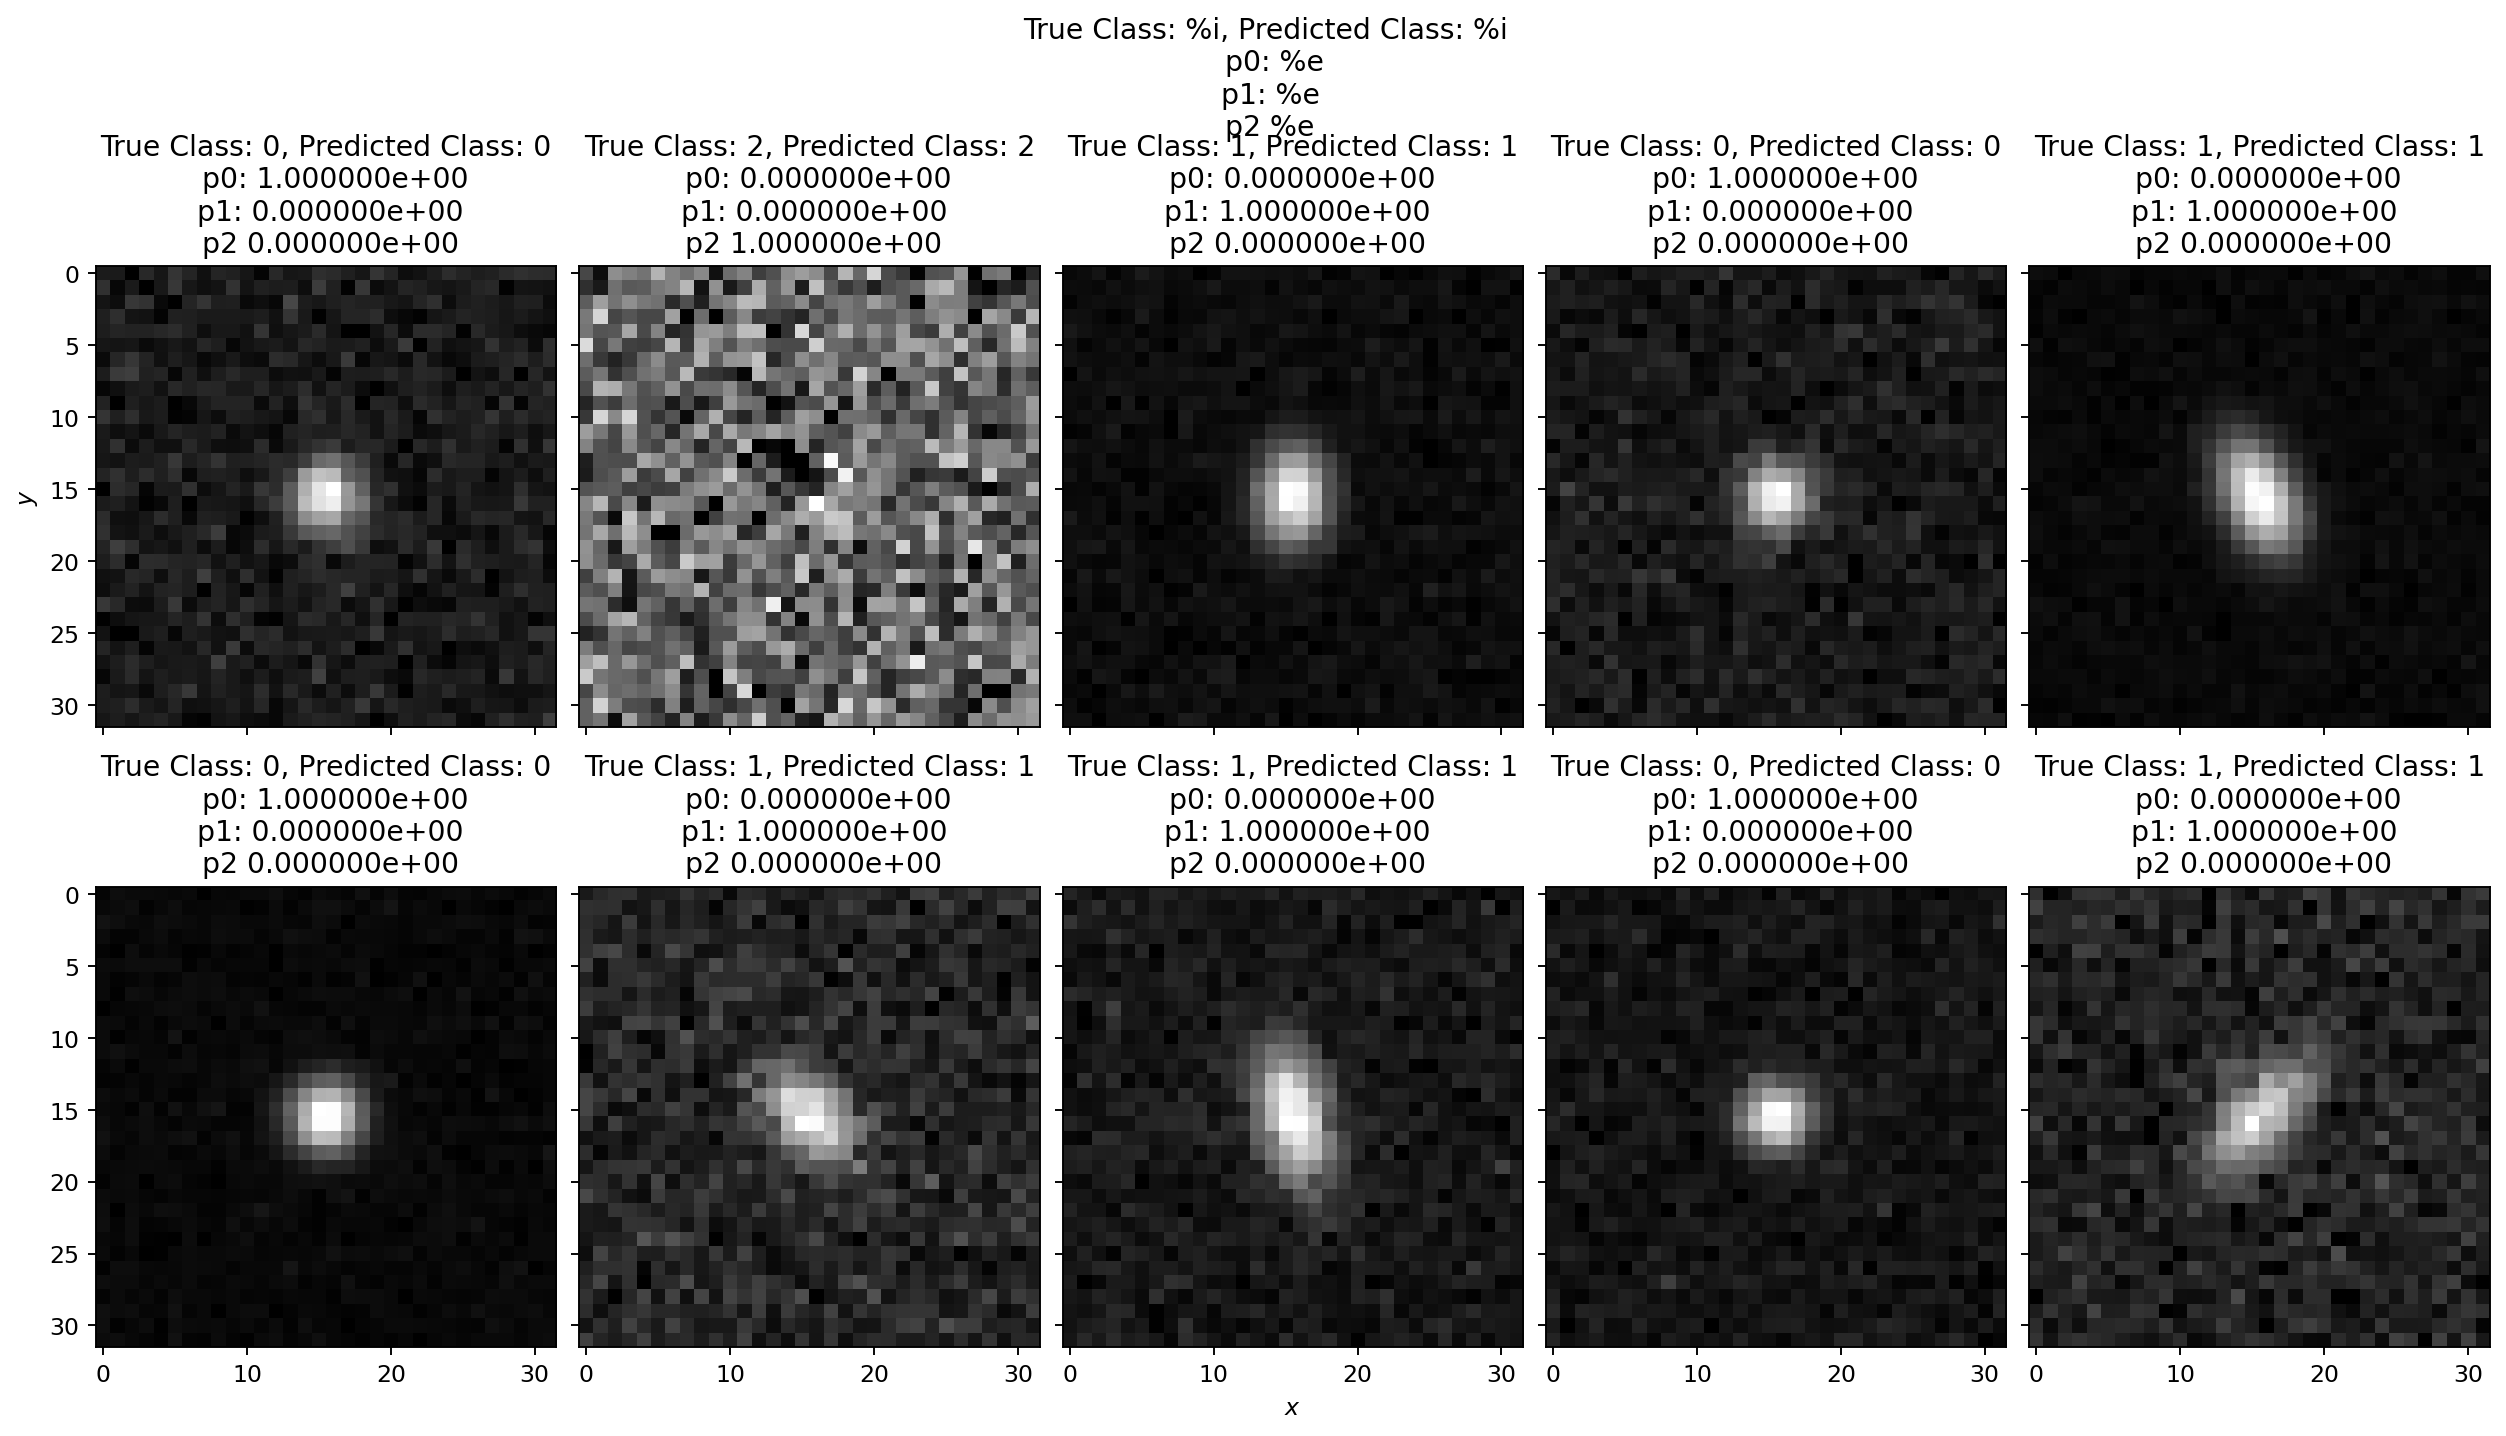

In [43]:
# plot a few stamps to see what we are trying to classify
plot_image_array(data_test, figsize=[16,10], subtitle=True, classes=class_test, class_true=class_test)

### split the sample into training, validation and test data sets

In [9]:
from astroML.utils import split_samples
# split the samples into training, validation and test data sets
# for definitions, see https://machinelearningmastery.com/difference-test-validation-datasets/
(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class, 
                                                                                        [0.7,0.1,0.2])
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)
print ('Number of samples in the training ({}); test ({}); and validation ({}) data sets'.format(data_train.shape[0], 
                                                                                    data_test.shape[0],
                                                                                   data_val.shape[0]))

Number of samples in the training (2100); test (600); and validation (300) data sets


### and now run CNN (ResNet50): very slow, 4-5 hours! 
 (runtime scales with n_epochs; sometimes only 50-100 is sufficient)

In [11]:
resnet50_model = ResNet50(input_shape=(32, 32, 1), classes=3)
resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=200
%time resnet_model_history = resnet50_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1, validation_data=(data_val, class_val), shuffle=True)

Epoch 1/200
9/9 [==============================] - 59s 6s/step - loss: 2.0110 - accuracy: 0.6305 - val_loss: 1.0965 - val_accuracy: 0.3667
Epoch 2/200
9/9 [==============================] - 56s 6s/step - loss: 1.4677 - accuracy: 0.7510 - val_loss: 1.1227 - val_accuracy: 0.3300
Epoch 3/200
9/9 [==============================] - 61s 7s/step - loss: 0.8124 - accuracy: 0.8338 - val_loss: 1.1064 - val_accuracy: 0.3300
Epoch 4/200
9/9 [==============================] - 87s 10s/step - loss: 0.5942 - accuracy: 0.8705 - val_loss: 1.1384 - val_accuracy: 0.3300
Epoch 5/200
9/9 [==============================] - 90s 10s/step - loss: 0.1312 - accuracy: 0.9686 - val_loss: 1.1766 - val_accuracy: 0.3300
Epoch 6/200
9/9 [==============================] - 69s 8s/step - loss: 0.0284 - accuracy: 0.9905 - val_loss: 1.1984 - val_accuracy: 0.3300
Epoch 7/200
9/9 [==============================] - 67s 7s/step - loss: 0.0271 - accuracy: 0.9910 - val_loss: 1.2138 - val_accuracy: 0.3300
Epoch 8/200
9/9 [========

Epoch 117/200
9/9 [==============================] - 112s 11s/step - loss: 0.2803 - accuracy: 0.9890 - val_loss: 1.2236 - val_accuracy: 0.7933
Epoch 118/200
9/9 [==============================] - 117s 13s/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 1.3531 - val_accuracy: 0.7533
Epoch 119/200
9/9 [==============================] - 125s 14s/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 1.0977 - val_accuracy: 0.8067
Epoch 120/200
9/9 [==============================] - 137s 15s/step - loss: 7.2418e-04 - accuracy: 1.0000 - val_loss: 0.9933 - val_accuracy: 0.8200
Epoch 121/200
9/9 [==============================] - 136s 15s/step - loss: 7.8223e-04 - accuracy: 1.0000 - val_loss: 1.1208 - val_accuracy: 0.7733
Epoch 122/200
9/9 [==============================] - 185s 21s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7435 - val_accuracy: 0.8733
Epoch 123/200
9/9 [==============================] - 165s 18s/step - loss: 5.8889e-04 - accuracy: 1.0000 - val_loss: 0.6864 - val_accu

## analyze classification results

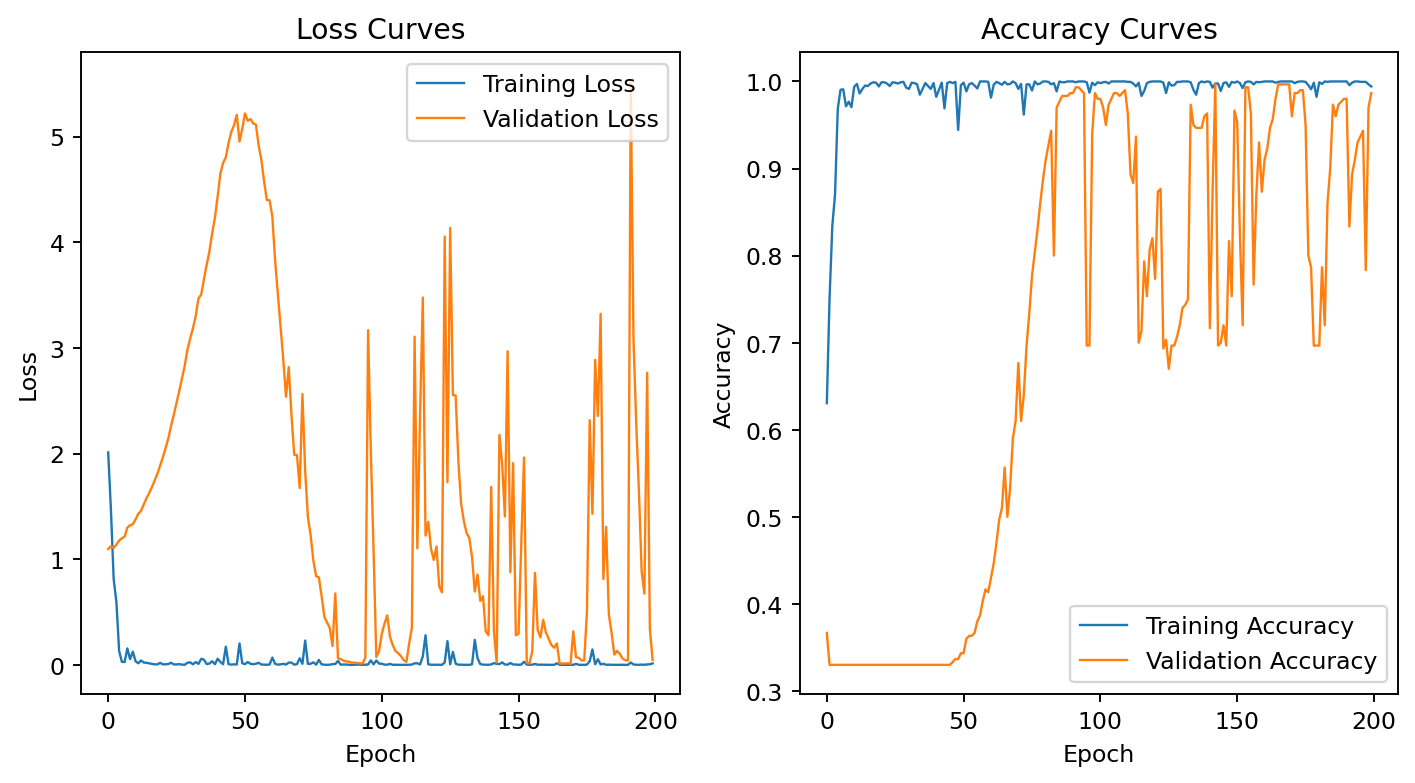

In [14]:
# plot the training history
plot_model_history(resnet_model_history)

### Note: the training accuracy is essentially 100% after only 20 epochs; however, the validation accuracy keeps oscillating between 70% and 100%

## now we will use the test subsample which was never used in training to obtain another estimate of performance

In [ ]:
# predicted class (this will be (600, 3) array - we actually get probabilities for each class)
Rclasses = resnet50_model.predict(data_test)

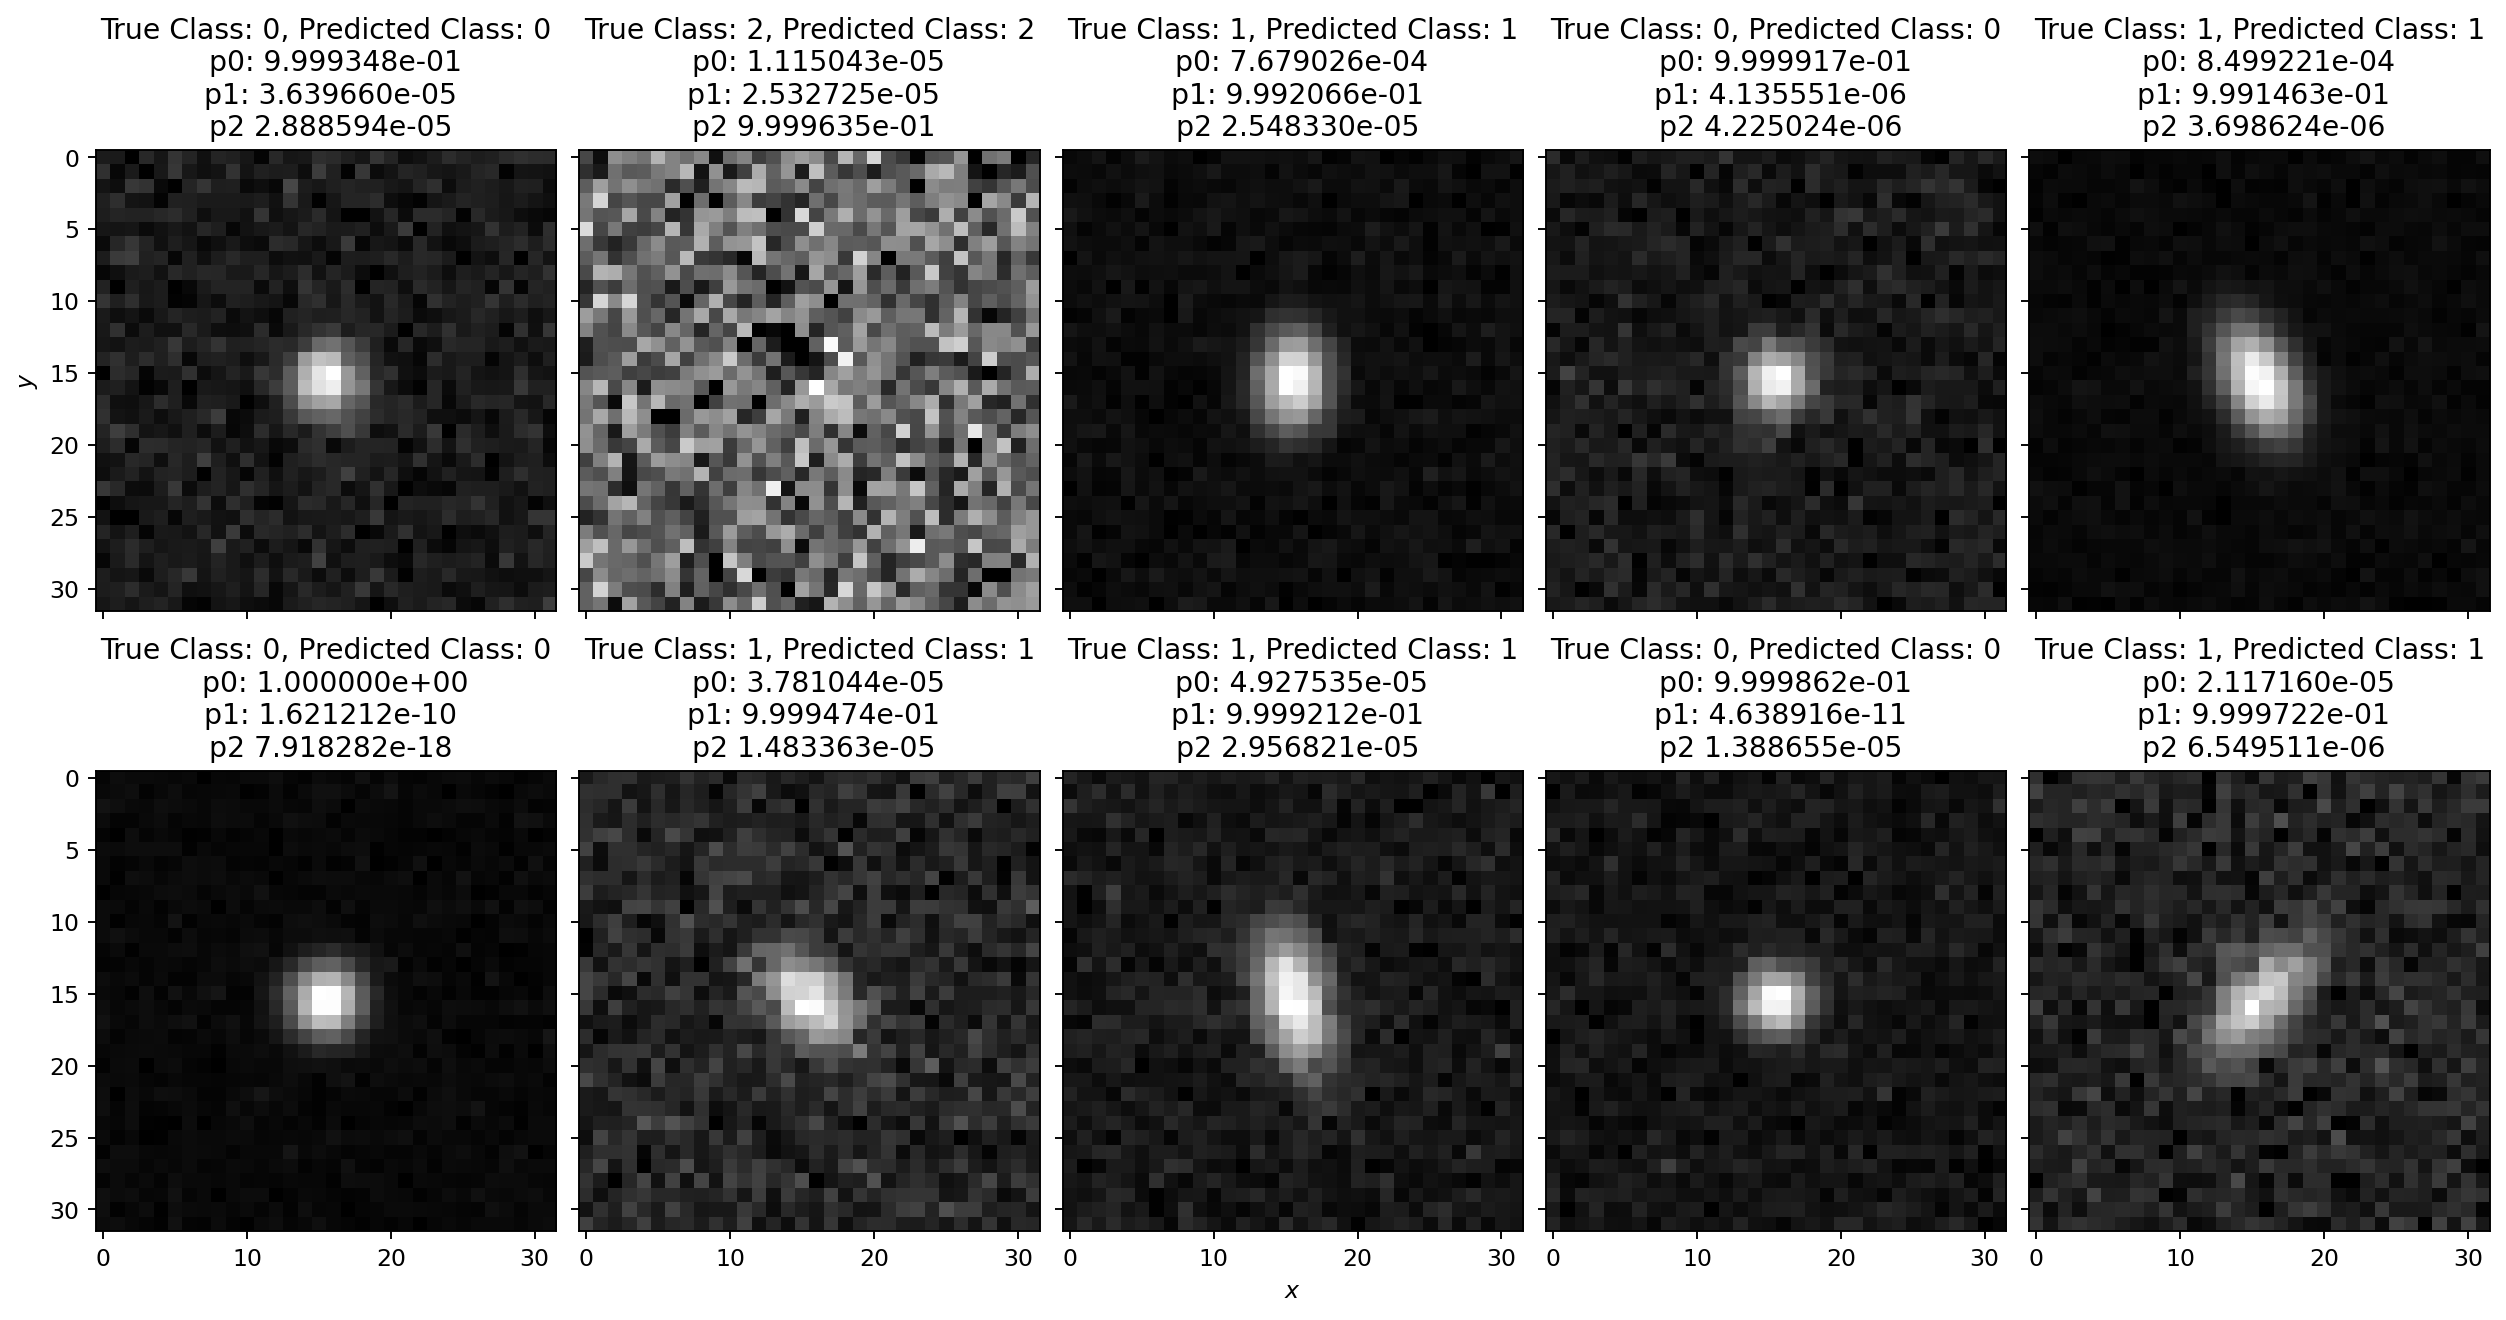

In [96]:
# plot example classifications
plot_image_array(data_test, figsize=[16,10], subtitle=True, classes=Rclasses, class_true=class_test)

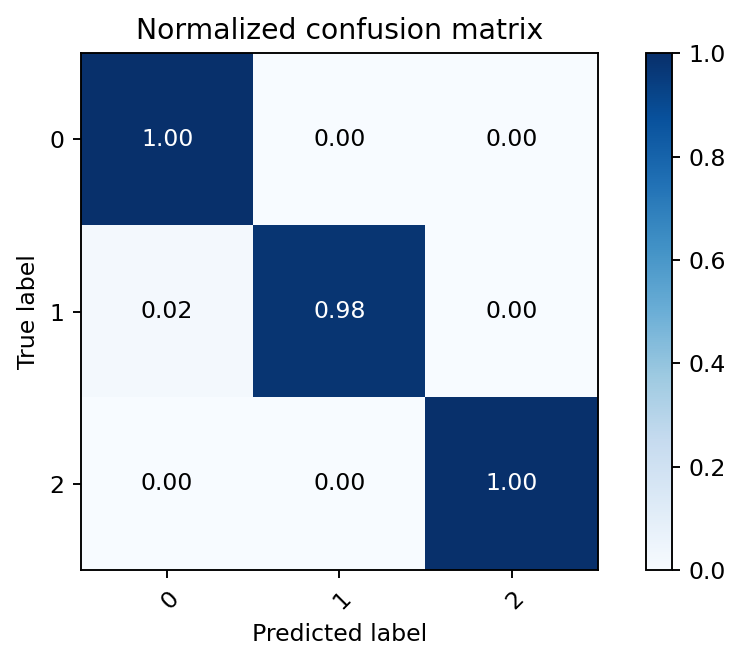

In [12]:
# plot the confusion matrix
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(Rclasses,axis=1), normalize=True,
                      title='Normalized confusion matrix')

## that is quite an amazing performance! (though note that it was SNR>50 dataset)

### there are only 4 misclassified stamps, let's see them! 

In [44]:
# note that here we adopt the class with the highest probability as the highest class
tC = np.argmax(class_test,axis=1)
aC = np.argmax(Rclasses,axis=1)
Nok = 0
Ndata = np.shape(class_test)[0]
good = np.ones(Ndata)
for i in range(0, Ndata):
    if (tC[i] == aC[i]):
        Nok += 1
    else:
        good[i] = 0
print('Overall classification accuracy for test sample:', Nok/Ndata)

Overall classification accuracy for test sample: 0.9933333333333333


In [98]:
# let's see what is true class and the predicted probabilities for all 3 classes
for i in range(0, Ndata):
    if (good[i]==0):
        print(tC[i], aC[i], Rclasses[i,:])

1 0 [0.72  0.279 0.001]
1 0 [9.707e-01 2.887e-02 4.597e-04]
1 0 [6.482e-01 3.512e-01 5.332e-04]
1 0 [9.732e-01 2.662e-02 2.235e-04]


### So 4 trailed sources are miclassified as stars - they were probably not very elongated, let's see...

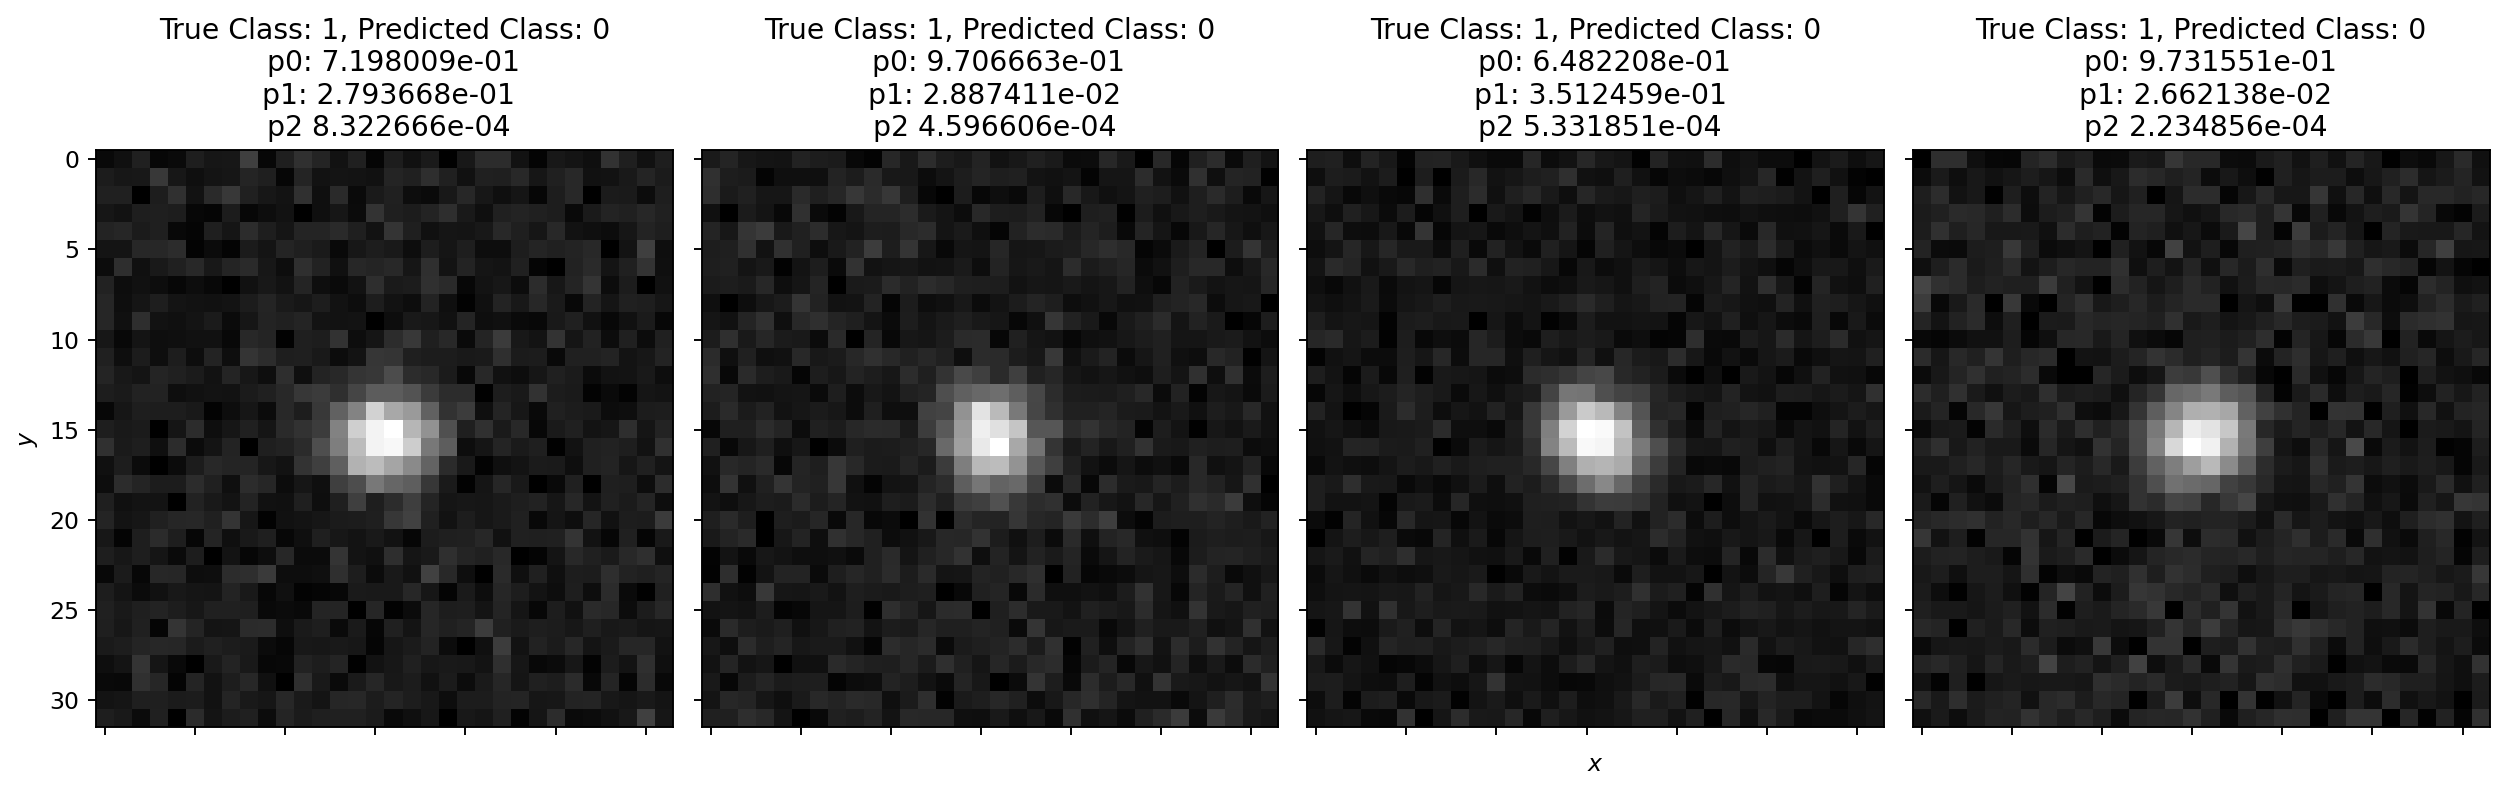

In [89]:
# plot misclassified stamps 
misfits = data_test[good==0]
trueClass = class_test[good==0]
predClass = Rclasses[good==0] 
plot_image_array(misfits, nrows=1, ncols=4, figsize=[16,5], subtitle=True, classes=predClass, class_true=trueClass)

## How many model parameters did we fit? We can find that information as follows

In [90]:
# print model summary
resnet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

### Wow, 23 million parameters! How many pixels did we fit? Each image is 32x32 pixels  and we trained on 2100 images, so there are more model parameters than input data! How can that be? 

### Answer: regularization. 

## Interpreting networks: where is a network looking
Occulsion maps, saliency maps, class activation maps are all techniques for expressing which pixels contribute to classification. These are attempts to reduce the "black box" nature of the networks. The simplest of these is the occlussion map where we part of an image and calculate the probability of it belonging to a class. If the probability decreases the occluded part of the image is assumed to be important. If there is no change in probability the occluded pixels are not assumed to be important. A simple implementation of this is shown here.

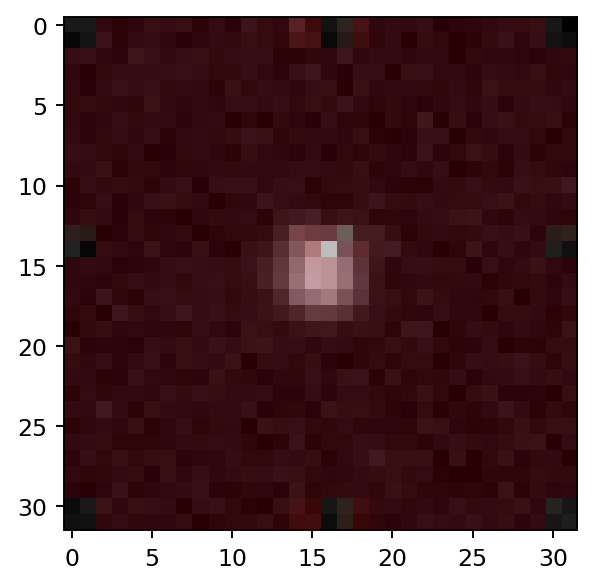

In [103]:
model = resnet50_model
image_number = 11
stampSize = 32

kernel_size=5
input_stamp = data_test[image_number].reshape(stampSize,stampSize)
i = 0
j=0
heatmap = []
keras_stamps = []
for j in range(stampSize+1-kernel_size):
    for i in range(stampSize+1-kernel_size):
        img = np.copy(input_stamp)
        img[i:i+kernel_size,j:j+kernel_size] = 0
        img = normalize_image(img)
        keras_stamps.append(img)
keras_stamps = np.array(keras_stamps).reshape([-1,stampSize,stampSize,1])
probs = 1. - model.predict(keras_stamps)
heatmap = probs[:,1].reshape(stampSize+1-kernel_size,stampSize+1-kernel_size)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

# pad heatmap to same size as original image
heatmap = np.pad(heatmap, pad_width=np.int(kernel_size/2), mode='minimum')

# use the base cmap to create transparent overlay
mycmap = transparent_cmap(plt.cm.Reds)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(data_test[image_number].reshape(stampSize,stampSize), cmap='gray')
ax.imshow(np.array(heatmap), alpha=0.5, cmap=mycmap)